# Определение перспективного тарифа

План:
1. Изучение и подготовка данных
2. Анализ данных
3. Проверка гипотез
4. Выводы

## ИЗУЧЕНИЕ И ПОДГОТОВКА ДАННЫХ

## I. Исходные таблицы

###  Таблица пользователей

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

users = pd.read_csv('users.csv')
print(users.info())
print()
display(users.head())
print()

# Проверим, совпадает ли число уникальных пользователей с числом строк в таблице
print(users.user_id.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None



,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



500


Дубликатов нет. Все данные в таблицы принадлежат к типу object. Формат даты предполагается такой: год-месяц_день. Нужно привести числа к типу int, даты - к datetime. Поскольку исследование посвящено 2018 году, NaNы в столбце churn_date можно заполнить значением 2019-01-01.

In [2]:
users = users.fillna('2019-01-01')
users.churn_date = pd.to_datetime(users.churn_date, format = '%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format = '%Y-%m-%d')
users.user_id = pd.to_numeric(users.user_id)
users.user_id = pd.to_numeric(users.user_id)
users.age = pd.to_numeric(users.age)
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


### Таблица тарифов

In [3]:
tariffs = pd.read_csv('tariffs.csv')
print(tariffs.info())
display(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В этой таблице неудобно то, что трафик считается то в гигабайтах, то в мегабайтах. Поскольку цена установлена за гигабайт, лучше заменить 'mb_per_month_included' на gb_included, а значения поменять на 15 и 30. Столбец 'tariff_name' стоит переименовать в 'tariff' для удобства дальнейшего объединения с другими таблицами.

In [4]:
tariffs.set_axis(['messages_included', 'gb_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff'], axis = 'columns', inplace = True)
tariffs['gb_included'] = (tariffs.gb_included / 1024).astype('int')
display(tariffs)

,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Таблица звонков

In [5]:
calls = pd.read_csv('calls.csv')
print(calls.info())
print()
display(calls.head())
print()

# Дубликаты
print(calls.id.duplicated().sum())
print()
# Проверим количество уникальных пользователей в этой таблице
#(и ниже сделаем о же самое для сообщений и интернета)
print(calls.user_id.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None



,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



0

492


Дубликатов нет. Нужно изменить формат даты, избавиться от пропущенных звонков, длительность оставшихся - округлить в большую сторону и привести к типу int (так как тариф поминутный). Id привязан к user_id, поэтому состоит из двух частей, разделенных нижним подчеркиванием. Его можно оставить в таком виде, потому что арифметические операции с ним выполнять не нужно.

In [6]:
# Формат даты
calls.call_date = pd.to_datetime(calls.call_date, format = '%Y-%m-%d')
# Пропущенные звонки
calls = calls[calls.duration != 0.00].reset_index(drop=True)
# Округление длительности в большую сторону
calls.duration = calls.duration // 1 + 1
# Целочисленный тип длительности
calls.duration = calls.duration.astype('int')
print(calls.info())
print()
display(calls.head())
print()
# Проверим, не изменилось ли количество пользователей после удаления пропущенных звонков
print(calls.user_id.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         162994 non-null  object        
 1   call_date  162994 non-null  datetime64[ns]
 2   duration   162994 non-null  int32         
 3   user_id    162994 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 4.4+ MB
None



,id,call_date,duration,user_id
0,1000_2,2018-06-11,3,1000
1,1000_3,2018-09-21,14,1000
2,1000_4,2018-12-15,6,1000
3,1000_7,2018-08-22,19,1000
4,1000_8,2018-09-15,19,1000



492


### Таблица сообщений

In [7]:
messages = pd.read_csv('messages.csv')
print(messages.info())
print()
display(messages.head())
print()
# Дубликаты
print(messages.id.duplicated().sum())
print()
# Количество уникальных пользователей
print(messages.user_id.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None



,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



0

426


Дубликатов нет. Нужно исправить формат даты.

In [8]:
# Формат даты
messages.message_date = pd.to_datetime(messages.message_date, format = '%Y-%m-%d')
print(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
None


### Таблица мобильного интернета

In [9]:
internet = pd.read_csv('internet.csv')
print(internet.info())
print()
display(internet.head(15))
print()
# Дубликаты
print(internet.id.duplicated().sum())
print()
# Количество уникальных пользователей
print(internet.user_id.nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None



,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000



0

497


Дубликатов нет. Нужно удалить непонятный столбец Unnamed (судя по всему, это результат переустановки индекса) и исправить формат даты. Также избавимся от нулевых значений столбца mb_used

In [10]:
# Удаление столбца 'Unnamed: 0'
internet = internet.drop(columns = 'Unnamed: 0')
# Удаление нулевых интернет-сессий
internet = internet[internet.mb_used != 0.00].reset_index(drop=True)
# Формат даты
internet.session_date = pd.to_datetime(internet.session_date, format = '%Y-%m-%d')
print(internet.info())
print()
display(internet.head())
print()
print(internet.user_id.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  float64       
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.0+ MB
None



,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000



497


В таблице пользователей - 500 пользователей. В таблице звонков - 492 пользователя, в таблице сообщений - 426, интернета - 497. Верочтно, эти выборки сильно пересекаются, и можно будет впоследствии объединять эти таблицы по столбцу user_id.

## II. Данные по месяцам

### Число месяцев использования тарифа для каждого пользователя

Пояснение: абонентская плата обычно списывается в начале месяца, при этом начало месяца - это не первое число, а число, когда абонент присоединился к тарифу. То есть если, например, абонент подключился к тарифу 20 мая и отключился 10 сентября, то он заплатит абонентскую плату 4 раза (последний раз - 20 августа). Поэтому кажется, что правильнее рассматривать не сколько он заплатил в мае-сентябре (5 календарных месяцев года), а сколько он заплатил за 4 месяца на тарифе. При таком подходе понятнее, как учитывать абонентскую плату. Таким образом, алгоритм такой: сначала посчитать разницу между датами подключения и отключения в месяцах, а затем в тех случаях, когда число месяца отключения не равно числу месяца подключения, добавить к этому показателю 1. Например, период с 10 апреля по 10 июля - это три полных месяца, а с 10 апреля по 9 июля - два, но на этот период приходятся три абонентские платы, поэтому нужно добавить 1.

In [11]:
# В таблице пользователей посчитаем разницу между датами подключения и отключения тарифа в месяцах
users['months_with_tariff'] = ((users.churn_date - users.reg_date) / np.timedelta64(1, 'M')).astype('int')

# У нас получилось число полных месяцев.
# Добавим к значению месяцев 1 в тех случаях, когда число месяца отключения от тарифа
# отличается от числа месяца подключения к тарифу


def increment_month(row):
    if row['churn_date'].day != row['reg_date'].day:
        row['months_with_tariff'] +=1
    return row
        
users = users.apply(increment_month, axis=1)
    
display(users.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,months_with_tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart,2
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra,5
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,8


### Количество звонков, длительность разговоров, смс и интернет трафик на каждого пользователя за весь период использования тарифа

In [12]:
# Для таблицы звонков посчитаем, сколько всего у каждого пользователя было звонков
# и их суммарную длительность за все время пользования тарифом
calls_grouped = calls.groupby('user_id').agg({'id': 'count', 'duration': 'sum'})
calls_grouped.set_axis(['calls_count', 'calls_duration'], axis = 'columns', inplace = True)
display(calls_grouped.head())
print()

# Для таблицы сообщений посчитаем, сколько у каждого пользователя
# было сообщений за все время пользования тарифом

messages_grouped = messages.groupby('user_id').agg({'id': 'count'})
messages_grouped.set_axis(['messages_count'], axis = 'columns', inplace = True)
display(messages_grouped.head())
print()

# Для таблицы интернета посчитаем весь трафик каждого пользователя за период пользования тарифом
internet_grouped = internet.groupby('user_id').agg({'mb_used': 'sum'})
display(internet_grouped.head())

print()
# Объединим данные в одну таблицу
all_service = internet_grouped.join([messages_grouped, calls_grouped])
display(all_service.head())

,calls_count,calls_duration
user_id,,
1000,293,2568
1001,92,844
1002,173,1520
1003,428,3823
1004,139,989


,messages_count
user_id,
1000,496
1002,70
1003,380
1004,1192
1005,552


,mb_used
user_id,
1000,107392.31
1001,32466.00
1002,116036.52
1003,57280.64
1004,149039.48


,mb_used,messages_count,calls_count,calls_duration
user_id,,,,
1000,107392.31,496.0,293.0,2568.0
1001,32466.00,NaN,92.0,844.0
1002,116036.52,70.0,173.0,1520.0
1003,57280.64,380.0,428.0,3823.0
1004,149039.48,1192.0,139.0,989.0


### Те же показатели по месяцам

In [13]:
# Объединим получившуюся таблицу по всем услугам с таблицей пользователей по столбцу 'user_id'
all_service_users = users.merge(all_service, on= 'user_id')
# Разделим количество звонков и общую длительность разговоов на количество месяцев использования 
# тарифа, чтобы получить среднемесячные данные и добавим получившиеся показатели в объединенную таблицу

all_service_users['calls_per_month'] = all_service_users.calls_count / all_service_users.months_with_tariff
all_service_users['calls_duration_per_month'] = all_service_users.calls_duration / all_service_users.months_with_tariff

# Посчитаем среднее количество сообщений в месяц

all_service_users['messages_per_month'] = all_service_users.messages_count / all_service_users.months_with_tariff

# Посчитаем среднемесячный трафик в гигабайтах с окрушлением до целых значений в большую сторону
all_service_users['gb_per_month'] = ((all_service_users.mb_used / all_service_users.months_with_tariff) // 1024 + 1).astype('int')

display(all_service_users.head())
print()
print(all_service_users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,months_with_tariff,mb_used,messages_count,calls_count,calls_duration,calls_per_month,calls_duration_per_month,messages_per_month,gb_per_month
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,107392.31,496.0,293.0,2568.0,36.625000,321.000000,62.0,14
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart,2,32466.00,NaN,92.0,844.0,46.000000,422.000000,NaN,16
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,7,116036.52,70.0,173.0,1520.0,24.714286,217.142857,10.0,17
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra,5,57280.64,380.0,428.0,3823.0,85.600000,764.600000,76.0,12
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,8,149039.48,1192.0,139.0,989.0,17.375000,123.625000,149.0,19



<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_id                   497 non-null    int64         
 1   age                       497 non-null    int64         
 2   churn_date                497 non-null    datetime64[ns]
 3   city                      497 non-null    object        
 4   first_name                497 non-null    object        
 5   last_name                 497 non-null    object        
 6   reg_date                  497 non-null    datetime64[ns]
 7   tariff                    497 non-null    object        
 8   months_with_tariff        497 non-null    int64         
 9   mb_used                   497 non-null    float64       
 10  messages_count            425 non-null    float64       
 11  calls_count               491 non-null    float64       
 12  calls_duration       

Итак, мы получили таблицу all_service_users, где в столбцах сalls_per_month и calls-duration_per_month хранятся среднемесячные данные по количеству звонков и их суммарной длительности для каждого пользователя в период использования тарифа, в столбце messages_per_month - среднемесячное число сообщений, в столбце gb_per_month - среднемесячный трафик.

### Месячный доход с каждого пользователя

In [14]:
# Объединим таблицы all_service_users и tariffs


all_with_tariffs = all_service_users.merge(tariffs, on = 'tariff', how = 'left')

In [15]:
# Из получившейся таблицы выберем столбцы, нужные нам, чтобы посчитать помесячную выручку с клиента

users_tariffs = all_with_tariffs[['user_id', 'city', 'tariff', 'calls_count', 'calls_duration_per_month', 'messages_per_month', 'gb_per_month', 'messages_included', 'gb_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute']]

In [16]:
# Посчитаем разницу между реальными тратами минут, смс и трафика и предусмотренными тарифом

users_tariffs['minutes_over'] = users_tariffs.calls_duration_per_month - users_tariffs.minutes_included
users_tariffs['messages_over'] = users_tariffs.messages_per_month - users_tariffs.messages_included
users_tariffs['gb_over'] = users_tariffs.gb_per_month - users_tariffs.gb_included

In [17]:
# Функция подсчета среднемесячного дохода с пользователя
def pay(row):
    # Переплата есть, если перерасход больше ноля
    over_pay = 0
    if row['minutes_over'] > 0:
        over_pay += (row['minutes_over'] * row['rub_per_minute'])
    if row['messages_over'] > 0:
        over_pay += (row['messages_over'] * row['rub_per_message'])
    if row['gb_over'] > 0:
        over_pay += (row['gb_over'] * row['rub_per_gb'])
        # Складываем абонентскую плату с переплатой
    return row['rub_monthly_fee'] + over_pay

users_tariffs['income'] = users_tariffs.apply(pay, axis =1)
display(users_tariffs.head())

,user_id,city,tariff,calls_count,calls_duration_per_month,messages_per_month,gb_per_month,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,gb_over,income
0,1000,Краснодар,ultra,293.0,321.000000,62.0,14,1000,30,3000,1950,150,1,1,-2679.000000,-938.0,-16,1950.0
1,1001,Москва,smart,92.0,422.000000,NaN,16,50,15,500,550,200,3,3,-78.000000,NaN,1,750.0
2,1002,Стерлитамак,smart,173.0,217.142857,10.0,17,50,15,500,550,200,3,3,-282.857143,-40.0,2,950.0
3,1003,Москва,ultra,428.0,764.600000,76.0,12,1000,30,3000,1950,150,1,1,-2235.400000,-924.0,-18,1950.0
4,1004,Новокузнецк,ultra,139.0,123.625000,149.0,19,1000,30,3000,1950,150,1,1,-2876.375000,-851.0,-11,1950.0


Теперь в столбце income таблицы users_tariffs - помесячная выручка с каждого клиента. Все необходимые для анализа показатели посчитаны.

## АНАЛИЗ ДАННЫХ

### Подсчет среднего, дисперсии и стандартного отклонения

In [18]:
# Посчитаем среднее, дисперсию и стандартное отклонение для пользователей каждого из тарифов по
# по минутам разговора, количеству сообщений, гигабайтам трафика и доходам от пользователя в месяц

averages_by_tariff = users_tariffs.groupby('tariff').agg({'calls_duration_per_month': 'mean', 'messages_per_month': 'mean', 'gb_per_month': 'mean', 'income': 'mean' })
averages_by_tariff.set_axis(['calls_duration_average', 'messages_average', 'gb_average', 'income_average'], axis = 'columns', inplace = True)

variance_by_tariff = users_tariffs.groupby('tariff').agg({'calls_duration_per_month': 'var', 'messages_per_month': 'var', 'gb_per_month': 'var', 'income': 'var' })
variance_by_tariff.set_axis(['calls_duration_variance', 'messages_variance', 'gb_variance', 'income_variance'], axis = 'columns', inplace = True)

std_by_tariff = users_tariffs.groupby('tariff').agg({'calls_duration_per_month': 'std', 'messages_per_month': 'std', 'gb_per_month': 'std', 'income': 'std' })
std_by_tariff.set_axis(['calls_duration_std_dev', 'messages_std_dev', 'gb_std_dev', 'income_std_dev'], axis = 'columns', inplace = True)


monthly_metrics = averages_by_tariff.join([variance_by_tariff, std_by_tariff])

display(monthly_metrics)

,calls_duration_average,messages_average,gb_average,income_average,calls_duration_variance,messages_variance,gb_variance,income_variance,calls_duration_std_dev,messages_std_dev,gb_std_dev,income_std_dev
tariff,,,,,,,,,,,,
smart,423.520136,37.613066,16.380000,1084.446396,20973.609932,621.699629,11.858052,268681.563782,144.822684,24.933905,3.443552,518.345024
ultra,556.610674,65.262922,19.986395,2010.204082,73156.418387,1884.710352,64.684745,39655.437517,270.474432,43.413251,8.042683,199.136731


In [19]:
monthly_metrics.T

tariff,smart,ultra
calls_duration_average,423.520136,556.610674
messages_average,37.613066,65.262922
gb_average,16.380000,19.986395
income_average,1084.446396,2010.204082
calls_duration_variance,20973.609932,73156.418387
messages_variance,621.699629,1884.710352
gb_variance,11.858052,64.684745
income_variance,268681.563782,39655.437517
calls_duration_std_dev,144.822684,270.474432
messages_std_dev,24.933905,43.413251


### Гистограммы

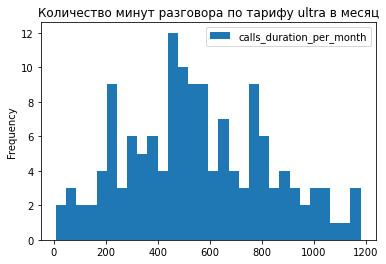

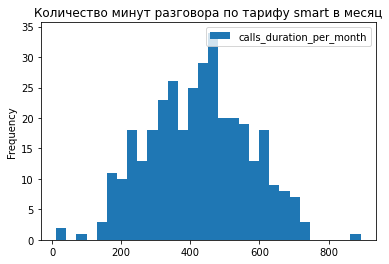

In [20]:
# Таблица для тарифа ultra
ultra = users_tariffs[users_tariffs.tariff == 'ultra']

# Таблица для тарифа smart
smart = users_tariffs[users_tariffs.tariff == 'smart']

#ultra.plot(kind='hist', y = 'calls_duration_per_month', bins = 30)
#smart.plot(kind='hist', y = 'calls_duration_per_month', bins = 30)

# Функция для создания гистограмм
def make_hist(table, column, title):
    return table.plot(kind='hist', y = column, bins = 30, title = title)

# Гистограммы минут разговоров
make_hist(ultra, 'calls_duration_per_month', "Количество минут разговора по тарифу ultra в месяц")
make_hist(smart, 'calls_duration_per_month', "Количество минут разговора по тарифу smart в месяц")
plt.show()

Два нормальных распределения со средними величинами в районе пика. Разброс значений для тарифа ultra заметно больше, чем для тарифа smart (стандартное отклонение почти в два раза больше). Среднее выше у ultra за счет клиентов, проговаривающих 800-1200 минут.

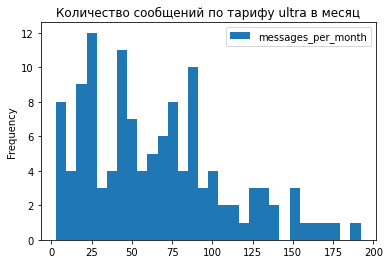

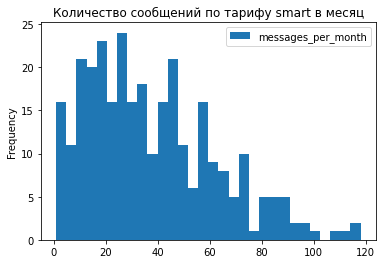

In [21]:
# Гистограмы сообщений
make_hist(ultra, 'messages_per_month', "Количество сообщений по тарифу ultra в месяц")
make_hist(smart, 'messages_per_month', "Количество сообщений по тарифу smart в месяц")
plt.show()

Сообщений значительно больше у пользователей тарифа ultra, разбос сильнее, стандартное отклонение больше, чем у smart. Среднее выше засчет тех, кто отправляет более 80 сообщений в месяц.

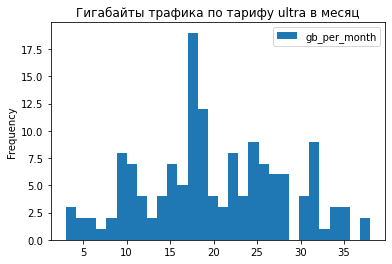

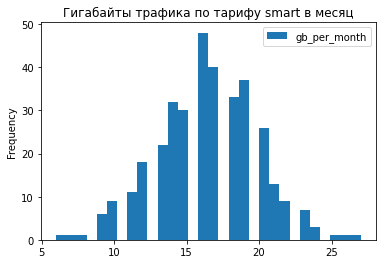

In [22]:
# Гистограммы трафика
make_hist(ultra, 'gb_per_month', "Гигабайты трафика по тарифу ultra в месяц")
make_hist(smart, 'gb_per_month', "Гигабайты трафика по тарифу smart в месяц")
plt.show()

Расход трафика в среднем немного побольше у пользователей тарифа ultra. Разброс заметно выше у ultra,  стандартное отклонение более чем в два раза выше. Среднее выше засчет тех, кто тратит по 25-35 гб в месяц.

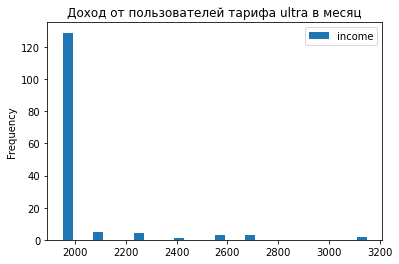

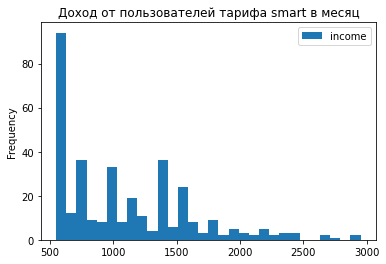

In [23]:
# Гистограммы дохода от пользователей тарифов
make_hist(ultra, 'income', "Доход от пользователей тарифа ultra в месяц")
make_hist(smart, 'income', "Доход от пользователей тарифа smart в месяц")
plt.show()

По гистограммам дохода видно, что пользователи тарифа ultra редко выходят за пределы лимитов в рамках абонентской платы. Засчет этого средний доход выше от пользователей smart. Среднее значение по smart около 2000 - очень далеко от пика. Пик - расходы в пределах абонентской платы, среднее "уехало" засчет тех, кто платит по 2000-3000 в месяц. Очевидно, реже пользуясь услугами оператора, некоторые пользователи smart (в этой выборке) переплачивают из-за низких лимитов, тщетно стараясь сэкономить на абонентской плате.

## ПРОВЕРКА ГИПОТЕЗ

### "Ультра" и "Смарт"

В этой выборке средний доход от пользователей smart почти в два раза выше, чем доход от пользователей ultra. Может ли это быть случайностью? Нам следует проверить, какова вероятность того, что различия между доходами от пользователей тарифов в этой выборке не отражают тенденций генеральной совокупности. Таким образом, наша нулевая гипотеза: средняя выручка от пользователей тарифов не различается. Альтернативная гипотеза - средний доход от пользователя тарифа smart выше, чем от пользователя ultra.
Поскольку речь идет о выборках из двух генеральных совокупностей, нужно использовать тест для равенства средних двух генеральных совокупностей. Чтобы максимально исключить возможность ошибки назначим очень низкое пороговое значение статистической знчимости: alpha= 0.01. 

In [24]:
#Сравнение средних доходов от ultra и smart. Дисперсия выборок не равна, как мы видели выше.
results = st.ttest_ind(ultra['income'], smart['income'], equal_var = False)
alpha = 0.01

print(results.pvalue)
print(alpha > results.pvalue)

2.3072139498098688e-107
True


p-значение получилось очень маленькое, меньше порогового значения статистической значимости. Это значит, что вероятность того, что нулевая гипотеза верна, очень мала, и ее можно отбросить и принять альтернативную - средний доход от пользователtq smart выше, чем от от пользователей ultra.

### Москва и другие города

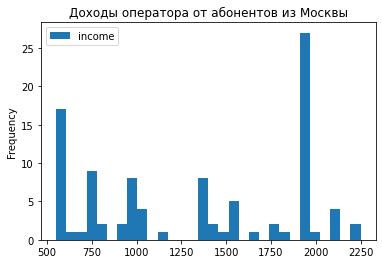

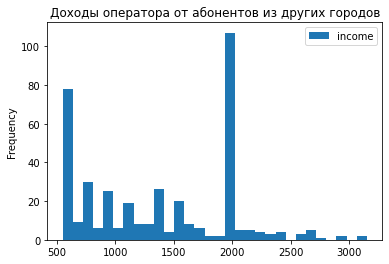

In [25]:
from_Moscow = users_tariffs.query('city == "Москва"')
not_from_Moscow = users_tariffs.query('city != "Москва"')

# Гистограммы по доходам от абонентов Москвы и других городов
make_hist(from_Moscow, 'income', "Доходы оператора от абонентов из Москвы")
make_hist(not_from_Moscow, 'income', "Доходы оператора от абонентов из других городов")
plt.show()

In [26]:
# Дисперсия выборок
print(from_Moscow.income.var())
print(not_from_Moscow.income.var())

330957.559379638
392245.0178016673


По гистограммам видно, что в наших выборках нет значимой разницы между средними доходами от москвичей и от немосквичей. Дисперсии выборок также довольно близки. Верно ли это для генеральных совокупностей? Так же, как и с тарифами, мы формулируем нулевую гипотезу о равенстве среднего двух генеральных совокупностей. Мы должны проверить на осонвании имеющейся у нас случайной выборки из этих совокупностей, насколько вероятно, что нулевая гипотеза верна, и можем ли мы ее отвергнуть. Альтернативная гипотеза: среднее двух генеральных совокупностей различно (а видное на гисограммах равенство среднего двух выборок - результат случайности).

In [27]:
# В данном случае, дисперсии равны, поэтому параметр equal_var не задаем

results2 = st.ttest_ind(from_Moscow['income'], not_from_Moscow['income'])
new_alpha = 0.05
print(results2.pvalue)

0.5667867457668359


Нулевую гипотезу нельзя отвергнуть, доходы мобильного оператора от москвичей в среднем не отличаются от доходов от жителей других городов.

## ОБЩИЕ ВЫВОДЫ

1. Поведение пользователей тарифов "Смарт" и "Ультра" различно. Пользователи тарифа "Смарт" предпочитают экономить на абонентской плате, и в результате значительная их часть превышают бесплатные лимиты минут, смс и гигабайтов трафика настолько, что средняя выручка от пользователей "Смарт" почти в два раза больше, чем от пользователей "Ультра". Пользователи тарифа "Ультра" редко выходят за пределы лимитов, средний доход от них близок к значению абонентской платы по тарифу.
2. Значимых различий в  доходах от москвичей и немосквичей не наблюдается.